# Sentiment Analytics on Twitter Tweets

In [ ]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
!pip install pysastrawi

     |████████████████████████████████| 215kB 2.6MB/s 


In [ ]:
!wget --quiet -P /content/Dataset https://raw.githubusercontent.com/fahmisalman/Miloo-Sentimen-Analysis/master/Dataset/negative_keyword_part1_revisi.csv
!wget --quiet -P /content/Dataset https://raw.githubusercontent.com/fahmisalman/Miloo-Sentimen-Analysis/master/Dataset/positive_keyword_part1_revisi.csv
!wget --quiet -P /content/Dataset https://raw.githubusercontent.com/fahmisalman/Miloo-Sentimen-Analysis/master/Dataset/unused_data.csv
!wget --quiet -P /content/Model https://raw.githubusercontent.com/fahmisalman/Miloo-Sentimen-Analysis/master/Model/key_norm.csv
!wget --quiet -P /content/Model https://raw.githubusercontent.com/fahmisalman/Miloo-Sentimen-Analysis/master/Model/kbba.txt
!wget --quiet -P /content/Model https://raw.githubusercontent.com/fahmisalman/Miloo-Sentimen-Analysis/master/Model/stopword_list_TALA.txt

## Import Dependencies

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

In [ ]:
df_pos = pd.read_csv('Dataset/positive_keyword_part1_revisi.csv')
df_pos['Sentimen'] = 'positive'
df_pos.head()

,text,keyword,Sentimen
0,Jam 8 alhamdulillah,alhamdulillah,positive
1,Alhamdulillah naik terus skrg dah lulus,alhamdulillah,positive
2,Alhamdulillah,alhamdulillah,positive
3,"Alhamdulillah, kenyang, kupat tahu nya banyak ...",alhamdulillah,positive
4,"Ada pepatah Greek mengatakan, “whom the gods l...",alhamdulillah,positive


In [ ]:
df_neg = pd.read_csv('Dataset/negative_keyword_part1_revisi.csv')
df_neg['Sentimen'] = 'negative'
df_neg.head()

,text,keyword,Sentimen
0,Chenle itu lumba lumba bukan hiu kampret,kampret,negative
1,@Fitokimiaa kampret dah,kampret,negative
2,U kno kampret,kampret,negative
3,Ada woe kampret kali dibilang penyakit :/,kampret,negative
4,"Emang janji tinggal janji, ketika liat duit, A...",kampret,negative


In [ ]:
df_ins = pd.read_csv('Dataset/unused_data.csv')[['text', 'Insult']]
df_ins.rename(columns={"Insult":"Sentimen"}, inplace=True)
df_ins['Sentimen'].replace([1, 0], ['negative', 'positive'], inplace=True)
df_ins['keyword'] = ''

In [ ]:
df_all = pd.concat([df_pos, df_neg, df_ins])
df_all.rename(columns={"text":"Text"}, inplace=True)

## Data Exploratory

Langkah pertama adalah melakukan pengamatan data untuk mengamati karakteristik dari suatu data sebelum dilakukan proses lebih lanjut, sehingga bisa menentukan proses apa yang harus dilakukan dalam tahap *preprocessing*.

Dalam percobaan ini dilakukan pengamatan terhadap distribusi kelas, dan distribusi kata baik itu secara keseluruhan maupun per masing-masing kelas.

### Class disstribution

In [ ]:
df_all = df_all.dropna()

In [ ]:
df = pd.DataFrame()
df_test = pd.DataFrame()

df['Text'], df_test['Text'], df['Sentimen'], df_test['Sentimen'] = train_test_split(df_all['Text'], df_all['Sentimen'], test_size=0.2, random_state=42, stratify=df_all['Sentimen'])

In [ ]:
df['Sentimen'].value_counts()

positive    20340
negative    11515
Name: Sentimen, dtype: int64

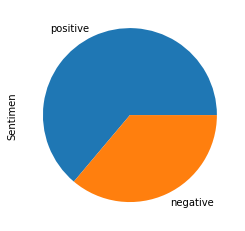

In [ ]:
df['Sentimen'].value_counts().plot(kind='pie')

### Words distribution

In [ ]:
df_explode = df['Text'].str.split().explode()
df_explode

7618    Dramanya
7618       bagus
7618      banget
7618        tapi
7618        tipe
          ...   
2454        ampe
2454      mampus
9026    semangat
9026          ya
9026       hidup
Name: Text, Length: 487464, dtype: object

In [ ]:
df_explode.value_counts()[:20]

lu        6565
yg        4431
di        4271
yang      3864
dan       3309
ya        2900
aku       2500
RT        2480
ada       2339
banget    2320
itu       2265
aja       2187
ga        2134
sama      1989
ini       1937
bisa      1792
mau       1712
orang     1675
gue       1605
gua       1547
Name: Text, dtype: int64

In [ ]:
df_explode.value_counts()[-20:]

Gadun...                                                                                                                                                                                                                1
@dodoe_dicko                                                                                                                                                                                                            1
Sebaya                                                                                                                                                                                                                  1
sacrifice                                                                                                                                                                                                               1
Bosque                                                                                                                          

In [ ]:
df_explode.value_counts().shape

(101217,)

In [ ]:
texts = ' '.join(df["Text"])

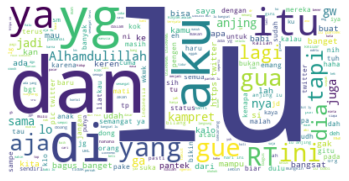

In [ ]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(texts)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Dari pengataman diatas dapat terlihat bahwa banyak tanda baca ataupun kata-kata yang mempunyai akar kata yang sama namun dianggap kata yang berbeda (contoh: "yg" dan "yang"), ada ketidakkonsistenan penulisan huruf kapital sehingga ada kata yang sama namun dianggap berbeda. Selain itu, kata-kata yang mempunyai frekuensi tertinggi merupakan kata-kata yang bisa digolongkan sebagai stopword dan akan dicoba juga penggunaan stemming untuk mengatasi masalah tersebut.


### Data Cleaning

Dari permasalahan diatas akan dilakukan proses sebagai berikut:

* text_lower: mengubah semua semua huruf kapital ke dalam huruf kecil
* text_cleaning: menghilangkan semua karakter kecuali karakter alfabet
* text_stemming: mengubah suatu kata ke dalam bentuk akarnya, pada percobaan ini algoritma yang digunakan adalah algoritma stemming [Nazief-Andriani](https://)
* stopwords_removal: menghilangkan semua kata yang terdapat di dalam stopwords, pada percobaan ini daftar stopword yang digunakan adalah daftar stopword hasil penelitian [(Tala et al., 2003)](https://pdfs.semanticscholar.org/8ed9/c7d54fd3f0b1ce3815b2eca82147b771ca8f.pdf)
* text_norm: mengubah kata singkatan menjadi kata asalnya. Daftar singkatan ini didapat dari https://www.kaggle.com/tiobagas/datasetsentimen#data_latih.json



In [ ]:
def text_lower(texts):
    return texts.lower()

def text_cleaning(texts):
    return ' '.join((re.sub(r'[^a-z]', ' ', texts)).split())

def text_stemming(texts):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(texts)

def stopwords_removal(texts):
    texts_token = texts.split()
    not_stopword = []
    for token in texts_token:
        if token not in stopwords:
            not_stopword.append(token)
    return ' '.join(not_stopword)

def text_norm(texts):
    words = texts.split()
    for i in range(len(words)):
        try:
            words[i] = normwords.loc[words[i]]['hasil']
        except:
            pass
    return ' '.join(words)

In [ ]:
def load_normwords(file):
    return pd.read_csv(file, index_col=['singkat'])

def load_stopwords(file):
    return [line.rstrip('\n\r') for line in open(file)]

In [ ]:
def preprocessing(texts):
    tx_lower = text_lower(texts)
    tx_clean = text_cleaning(tx_lower)
    tx_norm = text_norm(tx_clean)
    return tx_norm

In [ ]:
global stopwords
global normwords

stopwords = load_stopwords("Model/stopword_list_TALA.txt")
normwords = load_normwords("Model/key_norm.csv")

Ditambahkan beberapa kata ke dalam daftar stopword dan menghilangkan beberapa kata disesuaikan dengan kebutuhan untuk proses analisis sentimen

In [ ]:
stopwords.extend(['nya'])
stopwords.remove('tidak')
stopwords.remove('enggak')
stopwords.remove('lama')
stopwords.remove('bukan')

In [ ]:
df_norm = df['Text'].apply(preprocessing)

In [ ]:
df_norm

7618     dramanya bagus banget tapi tipe drama yang tid...
2045     operasi pembersihan pemerintah afghanistan tem...
1145     me setiap momen gonna be my eva kamu re the co...
10764    tuhan maafkan saya mengumbar aib ini saya yang...
9324     saya kesana ya kamu mau makan apa jhon coly yu...
                               ...                        
127      alhamdulillah siap melangkah maju bersama mini...
8928     ada ya sudah susah payah jalani training bulan...
6043     wahai kelean para penyuka maksiat segeralah ke...
2454     isss takut wkwkwk tidak berani deh tahan saja ...
9026                                     semangat ya hidup
Name: Text, Length: 31855, dtype: object

In [ ]:
df_norm.str.split().explode().value_counts()[:20]

kamu      13853
saya      11358
yang       9152
tidak      8931
ya         5003
di         4788
banget     4443
saja       3921
dan        3875
sudah      3778
sama       3296
itu        3284
ada        3265
ini        3123
kalau      3120
orang      2919
rt         2902
com        2480
jadi       2446
juga       2436
Name: Text, dtype: int64

In [ ]:
df_norm.str.split().explode().value_counts().shape

(55061,)

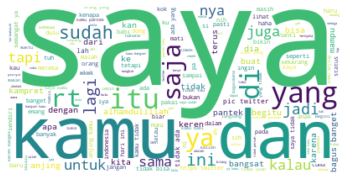

In [ ]:
df_explode = df_norm.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_norm))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_stem = df_norm.apply(text_stemming)

In [ ]:
df_stem

7618     drama bagus banget tapi tipe drama yang tidak ...
2045     operasi bersih perintah afghanistan tembak mat...
1145     me tiap momen gonna be my eva kamu re the coff...
10764    tuhan maaf saya umbar aib ini saya yang dulu h...
9324     saya kesana ya kamu mau makan apa jhon coly yu...
                               ...                        
127      alhamdulillah siap lang maju sama minigold sem...
8928     ada ya sudah susah payah jalan training bulan ...
6043     wahai kelean para suka maksiat segera kelean t...
2454     isss takut wkwkwk tidak berani deh tahan saja ...
9026                                     semangat ya hidup
Name: Text, Length: 31855, dtype: object

In [ ]:
df_stem.str.split().explode().value_counts()[:20]

kamu      13862
saya      11358
yang       9155
tidak      8967
ya         5039
di         4788
banget     4449
saja       3924
dan        3883
sudah      3813
sama       3536
ada        3466
itu        3357
orang      3235
ini        3179
kalau      3121
jadi       3078
rt         2902
mau        2512
com        2480
Name: Text, dtype: int64

In [ ]:
df_stem.str.split().explode().value_counts().shape

(46836,)

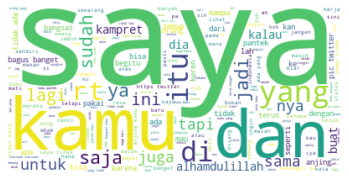

In [ ]:
df_explode = df_stem.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_stem))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_stop = df_stem.apply(stopwords_removal)

In [ ]:
df_stop

7618           drama bagus banget tipe drama tidak rewatch
2045     operasi bersih perintah afghanistan tembak mat...
1145     me momen gonna be my eva re the coffee that i ...
10764    tuhan maaf umbar aib hypersex jemput hidayah p...
9324     kesana ya makan jhon coly yuk lesbi kos sakit ...
                               ...                        
127      alhamdulillah lang maju minigold semuabisapuny...
8928     ya susah payah jalan training pontang panting ...
6043     kelean suka maksiat kelean tobat tinggal hijra...
2454       isss takut wkwkwk tidak berani deh tahan mampus
9026                                     semangat ya hidup
Name: Text, Length: 31855, dtype: object

In [ ]:
df_stop.str.split().explode().value_counts()[:20]

tidak            8967
ya               5039
banget           4449
orang            3235
com              2480
anjing           2429
twitter          2070
senang           2061
semangat         1948
bagus            1928
bangsat          1867
pantek           1781
babi             1753
alhamdulillah    1747
mampus           1730
kampret          1659
keren            1658
https            1461
tau              1241
lihat            1164
Name: Text, dtype: int64

In [ ]:
df_stop.str.split().explode().value_counts().shape

(46557,)

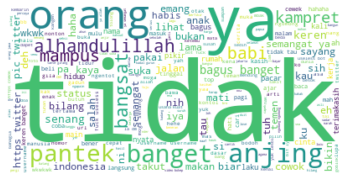

In [ ]:
df_explode = df_stop.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_stop))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df['Preprocessing'] = df_stop

In [ ]:
df.Text.loc[0]

0            Chenle itu lumba lumba bukan hiu kampret 
0                                  Jam 8 alhamdulillah
0    Yuk promo video erwin anak medan 6 buat 1jt.. ...
Name: Text, dtype: object

In [ ]:
df.Preprocessing.loc[0]

0                 chenle lumba lumba bukan hiu kampret
0                                    jam alhamdulillah
0    yuk promo video erwin anak medan jt via wa aga...
Name: Preprocessing, dtype: object

Dari kedua contoh diatas dapat terlihat bahwa setelah dilakukan *preprocessing* terdapat beberapa kata dan tanda baca yang hilang sehingga menghilangkan makna dari kalimat tersebut. Terlihat bahwa setelah penggunaan *preprocessing*, kalimat tersebut memiliki makna yang berbeda dibanding dengan kalimat awalnya, dikarenakan beberapa kata ada yang hilang, maupun berubah.

Dalam proses klasifikasi akan dibandingkan performansi dari penggunaan *preprocessing*.

### Words distribution for each class

#### Positive class

In [ ]:
df_positive = df[(df['Sentimen'] == 'positive')]

In [ ]:
df_positive.head()

,Text,Sentimen,Preprocessing
7618,Dramanya bagus banget tapi tipe drama yg gk ba...,positive,drama bagus banget tipe drama tidak rewatch
2045,"Operasi Pembersihan, Pemerintah Afghanistan Te...",positive,operasi bersih perintah afghanistan tembak mat...
10764,Tuhan maafkan aku mengumbar aib ini. Aku yang ...,positive,tuhan maaf umbar aib hypersex jemput hidayah p...
9324,"Aku ksana ya, kmu mw mkan apa?""@jhon_coly: @Yu...",positive,kesana ya makan jhon coly yuk lesbi kos sakit ...
9739,banyak yang langgar rules ya min?? semangat a,positive,langgar rules ya min semangat a


In [ ]:
df_positive.shape

(20340, 3)

In [ ]:
df_positive_explode = df_positive.Preprocessing.str.split().explode()

In [ ]:
df_positive_explode.value_counts()[:20]

tidak            5234
ya               3666
banget           3437
com              2195
orang            2107
senang           1985
semangat         1921
bagus            1852
twitter          1749
alhamdulillah    1737
keren            1623
https            1248
http              997
moga              887
pic               818
lihat             804
mati              706
username          705
sayang            695
sih               656
Name: Preprocessing, dtype: int64

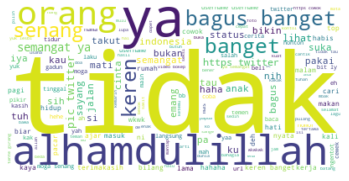

In [ ]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_positive.Preprocessing))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative class

In [ ]:
df_negative = df[(df['Sentimen'] == 'negative')]

In [ ]:
df_negative.head()

,Text,Sentimen,Preprocessing
1145,"Me : ""every moments gonna be myㅡ"" Eva : ""you'r...",negative,me momen gonna be my eva re the coffee that i ...
13887,[USERNAME] .... Itu bukan beda [USERNAME] .......,negative,username bukan beda username si username orang...
10813,"Selalu berujung ""kamu baik cip aku terlalu ban...",negative,ujung cip bangsat sae tai ayam
2278,Mampus guwe!,negative,mampus guwe
8815,Coli terus lu pantek,negative,coli pantek


In [ ]:
df_negative.shape

(11515, 3)

In [ ]:
df_negative_explode = df_negative.Preprocessing.str.split().explode()

In [ ]:
df_negative_explode.value_counts()[:20]

tidak      3733
anjing     2352
bangsat    1786
pantek     1751
babi       1738
mampus     1716
kampret    1650
ya         1373
orang      1128
banget     1012
emang       687
si          633
tau         600
sih         499
bilang      419
pakai       411
suka        367
bukan       366
lihat       360
tuh         340
Name: Preprocessing, dtype: int64

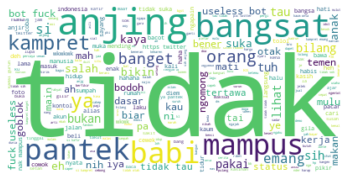

In [ ]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_negative.Preprocessing))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Preparation

In [ ]:
# convert class ['negative', 'positive'] into [0, 1]
y_train = np.array(list(df['Sentimen'].replace(['negative', 'positive'], [0, 1])))

In [ ]:
y_train

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
num_words = 30000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_norm)

In [ ]:
# Convert words into tokens
X_train_norm = tokenizer.texts_to_sequences(df_norm)

In [ ]:
X_train_norm[0]

[2349, 29, 7, 27, 1404, 556, 3, 4, 283, 2, 5456]

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

sequence_to_text(X_train_norm[0])

['dramanya',
 'bagus',
 'banget',
 'tapi',
 'tipe',
 'drama',
 'yang',
 'tidak',
 'bakal',
 'saya',
 'rewatch']

In [ ]:
print('Maximum review length: {}'.format(len(max(X_train_norm, key=len))))
print('Minimum review length: {}'.format(len(min(X_train_norm, key=len))))

Maximum review length: 1087
Minimum review length: 0


Dari hasil diatas terlihat bahwa panjang maksimum dari token dalam data latih adalah 83 token, lalu diberi *padding* untuk menyamakan dimensi dari setiap kalimat dalam data latih.

Maksimal panjang token diatur sebanyak 100 untuk mengantisipasi jika ada data yang memiliki token lebih 83 di data uji.

Pada percobaan ini saya menggunakan *pre-padding* atau memberi angka 0 di depan kalimat, hal tersebut dikarenakan jika menggunakan *post-padding* akan ada banyak angka 0 di akhir *sequence* yang menyebabkan proses klasifikasi tidak maksimal.

In [ ]:
X_train_norm_pad = pad_sequences(X_train_norm, maxlen=100, padding='pre', truncating='pre')

In [ ]:
X_train_norm_pad[100]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 34],
      dtype=int32)

## Classifier Construction

Dalam proses klasifikasi menggunakan metode Long Short Term Memory (LSTM) yang mempunyai 64 unit. Epoch yang digunakan adalah 10, dikarenakan setelah beberapa kali percobaan dilakukan, proses *training* sudah jenuh pada epoch tersebut.

In [ ]:
def model_structure(max_token=100, embedding_size=256):
    model = Sequential()
    model.add(Embedding(input_dim=num_words,
                      output_dim=embedding_size,
                      input_length=max_token,
                      name='Embedding_layer'))
    model.add(LSTM(units=64, name='LSTM_layer'))
    model.add(Dense(1, activation='sigmoid', name='Output_layer'))
    model.compile(loss='mean_squared_error',
                optimizer=Adam(lr=1e-3),
                metrics=['accuracy'])
    return model

def model_summary(model):
    print(model.summary())

def model_fit(model, X, y, epoch=10):
    return model.fit(X, y, epochs=epoch)

In [ ]:
def model_construction(X, y, num_words=7000, maxlen=100, embedding_size=256, epoch=10):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X)
    X_train = tokenizer.texts_to_sequences(X)
    X_train_pad = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre')
    model = model_structure(max_token=maxlen, embedding_size=embedding_size)
    model_summary(model)
    model_fit(model, X_train_pad, y, epoch=epoch)
    return model, tokenizer

In [ ]:
model_norm, tokenizer_norm = model_construction(df_norm, y_train, num_words=num_words, epoch=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          7680000   
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 7,762,241
Trainable params: 7,762,241
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 31855 samples
31855/31855 [==============================] - 193s 6ms

In [ ]:
with open('Model/tokenizer_norm.pickle', 'wb') as handle:
    pickle.dump(tokenizer_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_norm.save('Model/model_norm.h5')

In [ ]:
model_stem, tokenizer_stem = model_construction(df_stem, y_train, num_words=num_words, epoch=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          7680000   
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 7,762,241
Trainable params: 7,762,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 31855 samples
31855/31855 [==============================] - 195s 6ms/sample - loss: 0.0571 - acc: 0.9313


In [ ]:
with open('Model/tokenizer_stem.pickle', 'wb') as handle:
    pickle.dump(tokenizer_stem, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_stem.save('Model/model_stem.h5')

In [ ]:
model_stop, tokenizer_stop = model_construction(df_stop, y_train, num_words=num_words, epoch=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          7680000   
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 7,762,241
Trainable params: 7,762,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 31855 samples
31855/31855 [==============================] - 194s 6ms/sample - loss: 0.0568 - acc: 0.9299


In [ ]:
with open('Model/tokenizer_stop.pickle', 'wb') as handle:
    pickle.dump(tokenizer_stop, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_stop.save('Model/model_stop.h5')

## Model Evaluate

In [ ]:
df_test.head()

,Text,Sentimen
1827,"mau motoran, gak ada kawan,,, motoran sendiri,...",negative
2831,Keren kali,positive
10569,Dasar gaguna bangsat lu,negative
4986,"klo kita dah tau tmpat tujuan kita, takkan men...",positive
4876,"@plangdung Selamat malam, semoga harimu tadi m...",positive


In [ ]:
df_test.shape

(7964, 2)

In [ ]:
df_test['Sentimen'].value_counts()

positive    5085
negative    2879
Name: Sentimen, dtype: int64

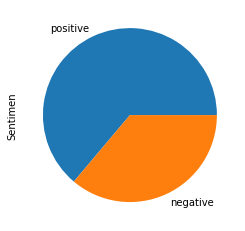

In [ ]:
df_test['Sentimen'].value_counts().plot(kind='pie')

In [ ]:
df_test_norm = df_test['Text'].apply(preprocessing)
df_test_stem = df_test_norm.apply(text_stemming)
df_test_stop = df_test_stem.apply(stopwords_removal)

In [ ]:
y_test = np.array(list(df_test['Sentimen'].replace(['negative', 'positive'], [0, 1])))

In [ ]:
def model_score(X, y, model, tokenizer, max_len=100):
    X_test = tokenizer.texts_to_sequences(X)
    X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
    return model.evaluate(X_test_pad, y, verbose=0)

def model_predict(X, y, model, tokenizer, max_len=100):
    X_test = tokenizer.texts_to_sequences(X)
    X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
    return model.predict_classes(X_test_pad)

### Model1 Evaluation

In [ ]:
model_score(df_test_norm, y_test, model_norm, tokenizer_norm)[1]

0.9465093

In [ ]:
y_pred_norm = model_predict(df_test_norm, y_test, model_norm, tokenizer_norm)

In [ ]:
confusion_matrix(y_test, y_pred_norm)

array([[2522,  357],
       [  69, 5016]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_norm).ravel()
(tn, fp, fn, tp)

(2522, 357, 69, 5016)

### Model2 Evaluation

In [ ]:
model_score(df_test_stem, y_test, model_stem, tokenizer_stem)[1]

0.94412357

In [ ]:
y_pred_stem = model_predict(df_test_stem, y_test, model_stem, tokenizer_stem)

In [ ]:
confusion_matrix(y_test, y_pred_stem)

array([[2561,  318],
       [ 127, 4958]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stem).ravel()
(tn, fp, fn, tp)

(2561, 318, 127, 4958)

### Model3 Evaluation

In [ ]:
model_score(df_test_stop, y_test, model_stop, tokenizer_stop)[1]

0.9436213

In [ ]:
y_pred_stop = model_predict(df_test_stop, y_test, model_stop, tokenizer_stop)

In [ ]:
confusion_matrix(y_test, y_pred_stop)

array([[2536,  343],
       [ 106, 4979]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stop).ravel()
(tn, fp, fn, tp)

(2536, 343, 106, 4979)

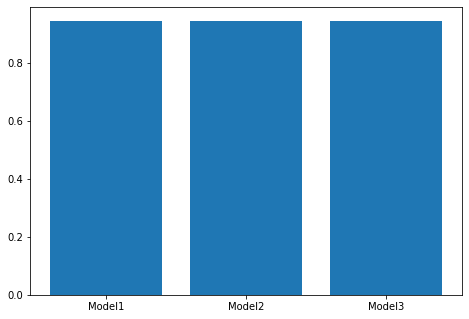

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
models = ['Model1', 'Model2', 'Model3']
scores = [model_score(df_test_norm, y_test, model_norm, tokenizer_norm)[1],
          model_score(df_test_stem, y_test, model_stem, tokenizer_stem)[1],
          model_score(df_test_stop, y_test, model_stop, tokenizer_stop)[1]]
ax.bar(models, scores)
plt.show()



---



---



In [ ]:
labels = ['negative', 'positive']

In [ ]:
sent = 'kamu baik banget'

sent_pre = preprocessing(sent)
X_test = tokenizer_norm.texts_to_sequences([sent_pre])
X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
labels[int(model_norm.predict_classes(X_test_pad))]

'positive'

In [ ]:
sent = 'kampret lu anjing babi'

sent_pre = preprocessing(sent)
X_test = tokenizer_norm.texts_to_sequences([sent_pre])
X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
labels[int(model_norm.predict_classes(X_test_pad))]

'negative'